In [1]:
import torch
import torchvision.transforms.functional
from torch import nn

In [2]:
class DoubleConvolution(nn.Module):
    def __init__(self,in_channels:int, out_channels:int):
        super().__init__()
        self.first=nn.Conv2d(in_channels,out_channels,kernel_size=3)
        self.act1=nn.ReLU()

        self.second=nn.Conv2d(out_channels,out_channels,kernel_size=3)
        self.act2=nn.ReLU()
    
    def forward(self,x:torch.Tensor):
        x=self.first(x)
        x=self.act1(x)
        x=self.second(x)
        return self.act2(x)

In [3]:
class DownSample(nn.Module):
    def __init__(self):
        super().__init__()

        self.pool=nn.MaxPool2d(2)
    
    def forward(self,x:torch.Tensor):
        out=self.pool(x)
        return out

In [4]:
class UpSample(nn.Module):
    def __init__(self, in_channels:int, out_channels:int):
        super().__init__()

        self.up=nn.ConvTranspose2d(in_channels,out_channels,kernel_size=2,stride=2)

    def forward(self,x:torch.Tensor):
        out=self.up(x)
        return out

In [5]:
class CropAndConcat(nn.Module):
    def forward(self,x:torch.Tensor, contracting_x:torch.Tensor):
        contracting_x=torchvision.transforms.functional.center_crop(contracting_x,[x.shape[2],x.shape[3]])
        x=torch.cat([x,contracting_x],dim=1)
        return x

In [6]:
class UNet(nn.Module):
    def __init__(self,in_channels:int, out_channels:int):
        super().__init__()
        self.down_conv=nn.ModuleList([DoubleConvolution(i,o) for i,o in 
                                     [(in_channels,64),(64,128),(128,256),(256,512)]])
        self.down_sample = nn.ModuleList([DownSample() for _ in range(4)])
        self.middle_conv = DoubleConvolution(512, 1024)
        self.up_sample = nn.ModuleList([UpSample(i, o) for i, o in
                                       [(1024, 512), (512, 256), (256, 128), (128, 64)]])
        self.up_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in
                                     [(1024, 512), (512, 256), (256, 128), (128, 64)]])
        self.concat = nn.ModuleList([CropAndConcat() for _ in range(4)])
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor):
        pass_through = []
        for i in range(len(self.down_conv)):
            x = self.down_conv[i](x)
            pass_through.append(x)
            x=self.down_sample[i](x)
        x=self.middle_conv(x)
        for i in range(len(self.up_conv)):
            x=self.up_sample[i](x)
            x=self.concat[i](x,pass_through.pop())
            x=self.up_conv[i](x)
        x=self.final_conv(x)
        return x

In [7]:
import torch
from torch import nn


class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)  # 7,3     3,1
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)


class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        out = x * self.ca(x)
        result = out * self.sa(out)
        return result


# 输入 N C H W,  输出 N C H W
# if __name__ == '__main__':
#     block = CBAM(64)
#     input = torch.rand(1, 64, 64, 64)
#     output = block(input)
#     print(input.size(), output.size())

In [3]:
import torch
import torchvision.transforms.functional
import torch.nn as nn
import torch.optim as optim
from utils import split_dataset,mydataloader
import matplotlib.pyplot as plt

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)  # 7,3     3,1
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)


class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        out = x * self.ca(x)
        result = out * self.sa(out)
        return result
    
class DoubleConvolution(nn.Module):
    def __init__(self,in_channels:int, out_channels:int):
        super().__init__()
        self.first=nn.Conv2d(in_channels,out_channels,kernel_size=3)
        self.act1=nn.ReLU()

        self.second=nn.Conv2d(out_channels,out_channels,kernel_size=3)
        self.act2=nn.ReLU()
    
    def forward(self,x:torch.Tensor):
        x=self.first(x)
        x=self.act1(x)
        x=self.second(x)
        return self.act2(x)
    
class DownSample(nn.Module):
    def __init__(self):
        super().__init__()

        self.pool=nn.MaxPool2d(2)
    
    def forward(self,x:torch.Tensor):
        out=self.pool(x)
        return out
    
class UpSample(nn.Module):
    def __init__(self, in_channels:int, out_channels:int):
        super().__init__()

        self.up=nn.ConvTranspose2d(in_channels,out_channels,kernel_size=2,stride=2)

    def forward(self,x:torch.Tensor):
        out=self.up(x)
        return out
    
class CropAndConcat(nn.Module):
    def forward(self,x:torch.Tensor, contracting_x:torch.Tensor):
        contracting_x=torchvision.transforms.functional.center_crop(contracting_x,[x.shape[2],x.shape[3]])
        x=torch.cat([x,contracting_x],dim=1)
        return x
    
class UNet(nn.Module):
    def __init__(self,in_channels:int, out_channels:int):
        super().__init__()
        self.down_conv=nn.ModuleList([DoubleConvolution(i,o) for i,o in 
                                     [(in_channels,64),(64,128),(128,256),(256,512)]])
        self.down_sample = nn.ModuleList([DownSample() for _ in range(4)])
        self.middle_conv = DoubleConvolution(512, 1024)
        self.up_sample = nn.ModuleList([UpSample(i, o) for i, o in
                                       [(1024, 512), (512, 256), (256, 128), (128, 64)]])
        self.up_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in
                                     [(1024, 512), (512, 256), (256, 128), (128, 64)]])
        self.concat = nn.ModuleList([CropAndConcat() for _ in range(4)])
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor):
        pass_through = []
        for i in range(len(self.down_conv)):
            x = self.down_conv[i](x)
            pass_through.append(x)
            x=self.down_sample[i](x)
        x=self.middle_conv(x)
        for i in range(len(self.up_conv)):
            x=self.up_sample[i](x)
            x=self.concat[i](x,pass_through.pop())
            x=self.up_conv[i](x)
        x=self.final_conv(x)
        return x

if __name__ == '__main__':
    device='cuda' if torch.cuda.is_available() else 'cpu'
    model=UNet(3,2).to(device)
    criterion=nn.CrossEntropyLoss(reduction='mean')
    val_criterion=nn.CrossEntropyLoss(reduction='mean')
    optimzier=optim.Adam(model.parameters(),lr=0.01)
    train_dataset,val_dataset,test_dataset=split_dataset()
    for i in range(0,10):
        train_dataloader=mydataloader(train_dataset,16)
        val_dataloader=mydataloader(val_dataset,16)
        for e,data in enumerate(train_dataloader):
            X,Y=data
            X=torch.tensor(X,dtype=torch.float32).to(device)
            Y=torch.tensor(Y[:,0,...],dtype=torch.long).to(device)
            pre=model(X)
            loss=criterion(pre,Y)
            optimzier.zero_grad()
            loss.backward()
            print(f'epoch:{i},batch:{e},loss:{loss}')
            optimzier.step()
        if i % 10 ==0:
            with torch.no_grad():
                model.eval()
                ls=0
                for X,Y in val_dataloader:
                    X=torch.tensor(X,dtype=torch.float32).to(device)
                    Y=torch.tensor(Y[:,0,...],dtype=torch.long).to(device)
                    pre=model(X)
                    ls+=val_criterion(pre,Y)
                print(f'epoch:{i},loss:{ls}')
                model.train()


ValueError: too many values to unpack (expected 2)

In [2]:
from utils import mydataloader,split_dataset
train_dataset,_,_=split_dataset()
x=mydataloader(train_dataset,16)

In [3]:
type(x)

generator

In [4]:
t,y=next(x)

In [5]:
type(t)

numpy.ndarray

In [6]:
t.shape

(16, 3, 512, 512)

In [8]:
y.shape

(16, 3, 324, 324)

(array([48498.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 56478.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

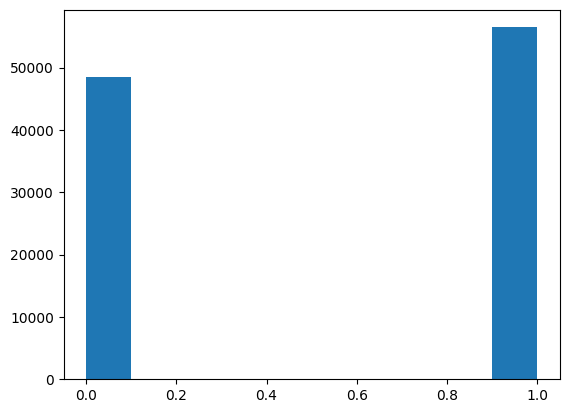

In [13]:
from matplotlib.pyplot import hist,imshow
hist(y[0,0].flatten())

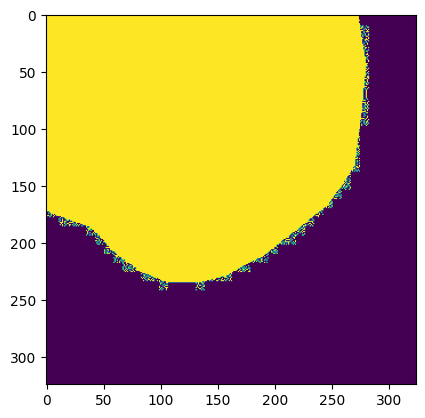

In [14]:
imshow(y[0,0])